# Baseline Model - Regime-Aware Volatility

We established:
- Log returns are approximately stationary
- Volatility clustering is present
- Market behavior is not structurally constant over long horizons

This notebook focus is on EWMA based volatility forecasting, and regime shift estimation. 

## Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# model
from arch import arch_model

In [3]:
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools

In [4]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# fix runtime autoclose in collab
import ipykernel
ipykernel.version_info

(6, 29, 5)

## Data Prep

In [6]:
df = yf.download('MSFT', start='2014-01-01', auto_adjust=True, progress=False)
df.dropna(inplace=True)
df['LogReturn'] = np.log(df['Close']).diff()
print("are dates sorted?:", df.index.is_monotonic_increasing)

are dates sorted?: True


In [7]:
df_train, df_test = train_test_split(df, shuffle=False, train_size=0.7)

In [8]:
# is variance modeling actually needed?
std_resid = StandardScaler().fit_transform(df[['LogReturn']].dropna())
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=12)
print("ARCH test on std resid p-value:", lm_pvalue)

ARCH test on std resid p-value: 2.12729220273545e-112


ARCH LM null hypothesis assume all coffiecient including the constant is 0. 
p <<< 0.05 conforms that volatility clusters and varying conditional volatility.

## Model Building

In [9]:
# target window
TARGET = 1 # in days

# scaling for numeric stability 
r_pct = df['LogReturn'].dropna() * 100 

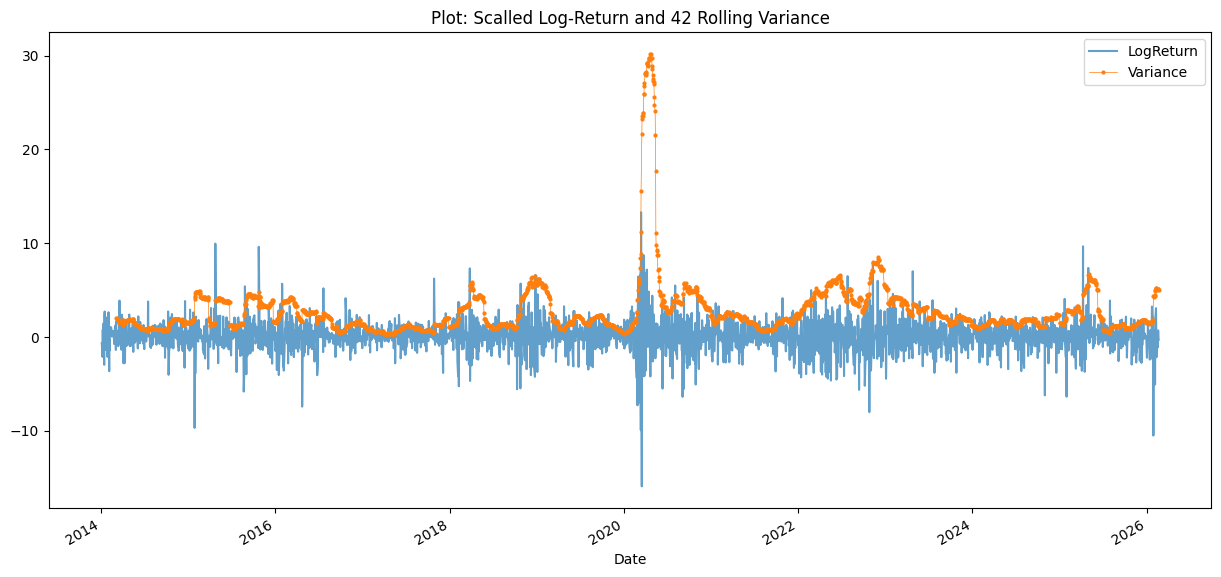

In [10]:
roll = 42
plt.figure(figsize=(15, 7))
(r_pct).plot(legend=True, alpha=0.7)
#(r_pct ** 2).plot(legend=True, label='variance')
(r_pct).rolling(roll).var().plot(legend=True, label='Variance', 
                               marker='o', markersize=2, linewidth=0.5)
plt.title(f"Plot: Scalled Log-Return and {roll} Rolling Variance")
plt.show()

GARCH might perform better.

In [11]:
target = 1 # volatility 1 day ahead

In [12]:
np.round(r_pct.mean(), 4)

np.float64(0.0839)

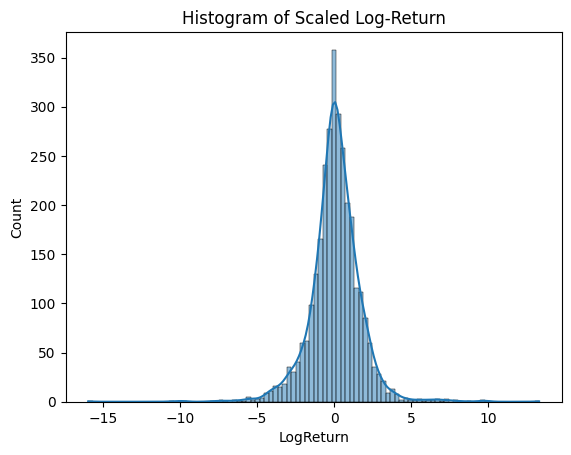

In [26]:
sns.histplot(r_pct, bins=100, kde=True)
plt.title('Histogram of Scaled Log-Return')
plt.show()

In [20]:
models = pd.DataFrame(columns=['model', 'aic', 'bic', 'lik'])

params = [1, 2, 5, 10, 15]
progress = 0
# p and q - based on squared return ACF plot
for p, q in itertools.product(params, repeat=2):
    progress += 1
    arch_fit = arch_model(r_pct.values, mean="Zero", vol='ARCH', p=p, dist='normal').fit(disp='off')
    garch_fit = arch_model(r_pct.values, mean='Zero', vol='GARCH', p=p, q=q, dist='normal').fit(disp='off')
    
    models.loc[f'arch{p}'] = arch_fit, arch_fit.aic, arch_fit.bic, arch_fit.loglikelihood
    models.loc[f'g{q}arch{p}'] = garch_fit, garch_fit.aic, garch_fit.bic, garch_fit.loglikelihood
    
    print(f"\rProgress: {progress} out of {len(params)**2} done", end='')
    

Progress: 25 out of 25 done

In [ ]:
print(f"best model as per AIC: {models['aic'].idxmin()}, with score: {models['aic'].min()}")
print(f"best model as per BIC: {models['bic'].idxmin()}, with score: {models['bic'].min()}")


best model as per AIC: arch15, with score: 11488.034147392136
best model as per BIC: g1arch1, with score: 11500.080596761569


In [32]:
models.sort_values(by='aic').head(5)

,model,aic,bic,lik
arch15,Zero Mean - ARCH Model...,11203.490374,11299.861969,-5585.745187
g1arch15,Zero Mean - GARCH Model...,11205.490374,11307.885194,-5585.745187
g1arch1,Zero Mean - GARCH Model...,11206.271579,11224.341253,-5600.135789
g2arch15,Zero Mean - GARCH Model...,11207.490373,11315.908417,-5585.745187
g1arch2,Zero Mean - GARCH Model...,11207.876176,11231.969075,-5599.938088


In [33]:
models.sort_values(by='bic').head(5)

,model,aic,bic,lik
g1arch1,Zero Mean - GARCH Model...,11206.271579,11224.341253,-5600.135789
g1arch2,Zero Mean - GARCH Model...,11207.876176,11231.969075,-5599.938088
g2arch1,Zero Mean - GARCH Model...,11208.271579,11232.364478,-5600.135790
g2arch2,Zero Mean - GARCH Model...,11209.909610,11240.025733,-5599.954805
g1arch5,Zero Mean - GARCH Model...,11211.061657,11253.224229,-5598.530828


The ACF plot suggested long memory, however GARCH(1,1) == short lag giving a very contrained shape fit. Loglikehood of returns given the model-fit suggest that GARCH(1,1) is even worse than others.

ARCH(15) == high lag with highest AIC probably be an overfitting the training data.

The log likehood of arch(15) and GARCH(15, 1) is same, suggesting lagged variance parameter isn't doing anything. 

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def diag(res, lags=20):
    # standardized residuals
    z = res.std_resid.dropna()

    lb_z = acorr_ljungbox(z, lags=[lags], return_df=True)
    lb_z2 = acorr_ljungbox(z**2, lags=[lags], return_df=True)

    # Engle ARCH LM on standardized residuals
    arch_lm = het_arch(z, nlags=lags)  # returns (LM stat, LM pval, F stat, F pval)

    return {
        "LjungBox z pval": float(lb_z["lb_pvalue"].iloc[0]),
        "LjungBox z^2 pval": float(lb_z2["lb_pvalue"].iloc[0]),
        "ARCH LM pval": float(arch_lm[1]),
    }

for name, res in models.items():
    print(name, diag(res, lags=20))


ARCH(1) {'LjungBox z pval': 0.0029704815872935724, 'LjungBox z^2 pval': 1.5517298895162623e-22, 'ARCH LM pval': 7.236779217405447e-13}
ARCH(5) {'LjungBox z pval': 0.19550989642853417, 'LjungBox z^2 pval': 0.7430591912940578, 'ARCH LM pval': 0.7265308526823129}
GARCH(1,1) {'LjungBox z pval': 0.24863951971446263, 'LjungBox z^2 pval': 0.9516727893896644, 'ARCH LM pval': 0.9459375199136096}
GARCH(2,1) {'LjungBox z pval': 0.24840355584553622, 'LjungBox z^2 pval': 0.9474372790460498, 'ARCH LM pval': 0.9428114212632708}
GARCH(1,2) {'LjungBox z pval': 0.24864236943226012, 'LjungBox z^2 pval': 0.951669493555462, 'ARCH LM pval': 0.9459316178443711}


In [27]:
print(f"Excess Kurtosis: {r_pct.kurtosis()}")

Excess Kurtosis: 8.385660257116495


The log-return have high kurtosis, suggesting fat tailed distributed. 

The fat tails is likely goverened by COVID-19 (e.g., large and rare event) influence parameter estimates and volatility dynamics.

Next steps:

* Try GARCH with Student-t errors.

* Test asymmetric models (GJR-GARCH / EGARCH).

* Compare out-of-sample, pre-covid, post-covid sample.

* Test  shift regimes as volatility processes often breaks

For now, focus on modeling returns; later extend to risk measures (VaR, Expected Shortfall) and forecasting performance evaluation.